In [1]:
include("model_2D_test.jl")

using SparseIR, Plots
#using OMEinsum
#using FastGaussQuadrature
import SparseIR: valueim, value
import SparseIR: fit
#using LinearAlgebra


struct IR_params
    U::Float64
    beta::Float64
    bw::Float64
    basis::FiniteTempBasis
    
    smpl_matsu::MatsubaraSampling64F
    smpl_tau::TauSampling64
    n_matsu::Int
    n_tau::Int
    smpl_wn::Vector{ComplexF64}
end

function set_IR(U::Float64, beta::Float64, bw::Float64, eps::Float64)
    basis = FiniteTempBasis(Fermionic(), beta, bw, eps)

    smpl_matsu = MatsubaraSampling(basis)
    n_matsu = size(smpl_matsu.sampling_points)[1]

    smpl_tau = TauSampling(basis)
    n_tau = size(smpl_tau.sampling_points)[1]

    smpl_wn = zeros(ComplexF64, n_matsu)
    for w in 1:n_matsu
        smpl_wn[w] = valueim(smpl_matsu.sampling_points[w], beta)
    end

    return U, beta, bw, basis, smpl_matsu, smpl_tau, n_matsu, n_tau, smpl_wn
end

mutable struct Green_Sigma
    g0_ir::Vector{ComplexF64}
    g0_tau::Vector{ComplexF64}
    g0_matsu::Vector{ComplexF64}

    g_ir::Vector{ComplexF64}
    g_matsu::Vector{ComplexF64}

    sigma_ir::Vector{ComplexF64}
    sigma_tau::Vector{ComplexF64}
    sigma_matsu::Vector{ComplexF64}
end

function init_zero_g(ir::IR_params)
    
    g0_tau = zeros(ComplexF64, ir.n_tau)
    g0_matsu = zeros(ComplexF64, ir.n_matsu)
    g0_ir = fit(ir.smpl_matsu, g0_matsu, dim=1)

    g_ir = zeros(ComplexF64, length(g0_ir))
    g_matsu = zeros(ComplexF64, ir.n_matsu)

    sigma_ir = zeros(ComplexF64, length(g0_ir))
    sigma_tau = zeros(ComplexF64, ir.n_tau)
    sigma_matsu = zeros(ComplexF64, ir.n_matsu)

    return g0_ir, g0_tau, g0_matsu, g_ir, g_matsu, sigma_ir, sigma_tau, sigma_matsu
end

init_zero_g (generic function with 1 method)

In [2]:
px = Parm(set_parm(["0.5","0.7", "-4.0", "0.01", "200"])...)

irx = IR_params(set_IR(8.0, 100.0, 8.0, 1e-8)...)
lamda_num::Int = 20
batch_num::Int = 80
w_num::Int = 1001
gx = Green_Sigma(init_zero_g(irx)...)
w_mesh = collect(-irx.bw:2irx.bw/(w_num-1):irx.bw)
kk = get_kk(px.K_SIZE)
println(px)

Parm(0.5, 0.7, -4.0, 0.01, 200, 2.5e-5)


In [3]:

function gk_m(p::Parm, k::Vector{Float64}, w::ComplexF64, g::Green_Sigma)
    e = set_H(k,p)
    gk = 1.0/(w - e - g.sig)
    return gk
end

function get_G0mlocal(p::Parm, k_BZ::Vector{Vector{Float64}}, w::ComplexF64, sw::Int, sigma::ComplexF64)
    gw_l = 0.0
    gl = 0.0
    if(sw == 1)
        for i in 1:length(k_BZ)
            e = set_H(k_BZ[i],p) - p.mu
            gk = 1.0/(w - e)
            gw_l += p.dk2 * gk
        end
    else
        for i in 1:length(k_BZ)
            e = set_H(k_BZ[i],p) - p.mu
            gk = 1.0/(w - e -sigma)
            gl += p.dk2 * gk
        end
        gw_l = 1.0/(1.0/gl + sigma)
    end
    return gw_l, gl
end

function MatsuToTau!(ir::IR_params, g::Green_Sigma)
    g.g0_ir = fit(ir.smpl_matsu, g.g0_matsu, dim=1)
    g.g_ir = fit(ir.smpl_matsu, g.g_matsu, dim=1)
    g.g0_tau = evaluate(ir.smpl_tau, g.g0_ir, dim=1)
end

function TauToMatsu!(ir::IR_params, g::Green_Sigma, γ::Float64)
    ir_new = fit(ir.smpl_tau, g.sigma_tau)
    diff = sum(abs.(ir_new .- g.sigma_ir))
    g.sigma_ir = (1.0-γ) .* g.sigma_ir .+ γ .* ir_new
    g.sigma_matsu = evaluate(ir.smpl_matsu, g.sigma_ir, dim=1)

    return diff
end

function update_g!(p::Parm, k_BZ::Vector{Vector{Float64}},sw::Int, ir::IR_params, g::Green_Sigma, γ::Float64)
    for w in 1:ir.n_matsu
        #g.g0_matsu[w], g.g_matsu[w] = get_G0mlocal(p, k_BZ, valueim(ir.smpl_matsu.sampling_points[w], ir.beta), sw, g.sigma_matsu[w])
        g.g0_matsu[w], g.g_matsu[w] = get_G0mlocal(p, k_BZ, ir.smpl_wn[w], sw, g.sigma_matsu[w])
    end
    MatsuToTau!(ir, g)
    g.sigma_tau = ir.U^2 .* (g.g0_tau).^2 .* g.g0_tau[end:-1:1]
    # .+ ir.U .* g.g0_tau
    diff = TauToMatsu!(ir, g, γ)
    return diff
end

update_g! (generic function with 1 method)

In [4]:

using Flux

function F_rho0(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    vec = g.g0_ir - ir.basis.s .* rho_ls
    return f = 0.5*real(vec'*vec) + λ*sum(abs.(rho_ls))
end

function fit_rho0w(ir::IR_params, g::Green_Sigma, l_num::Int, batch_num::Int, w_mesh::Vector{Float64})
    sn = range(-12.0, 0.0, length=l_num)
    lam_test = 10 .^ (sn)
    opt = ADAM()
    s_rho_l = rand(Float64, l_num, ir.n_matsu)
    s_F_rho = 1000.0 * ones(Float64, l_num)

    for ll in 1:l_num
        lam = lam_test[ll]
        for b in 1:batch_num
            rho_ll = rand(Float64, ir.n_matsu)
            F_old = 1000.0
            F_new = 1000.0
            for i in 1:10000
                grads = Flux.gradient(Flux.params(rho_ll)) do
                    F_rho0(ir, g, rho_ll, lam)
                end
                Flux.Optimise.update!(opt, Flux.params(rho_ll), grads)
                F_old = F_new
                F_new = F_rho0(ir, g, rho_ll, lam)
                if(abs(F_old-F_new)/abs(F_old)<1e-6)
                    break
                end
            end
            if(s_F_rho[ll] > F_rho0(ir, g, rho_ll, lam))
                s_rho_l[ll,:] = rho_ll
                s_F_rho[ll] = F_rho0(ir, g, rho_ll, lam)
            end
        end
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    ev = a .* lam_test .^ b ./ s_F_rho

    return lam_test, ev, s_rho_l

    #p1 = plot(lam_test, ev, xaxis=:log, yaxis=:log, marker=:circle)
    #savefig(p1,"./lambda_opt_G0.png")

    #it = findmax(ev)[2]
    #println(it)
    #rho_omega = -transpose(ir.basis.v(w_mesh)) * s_rho_l[it,:]
    #return rho_omega
end

fit_rho0w (generic function with 1 method)

In [5]:
function F_rho(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    vec = g.g_ir - ir.basis.s .* rho_ls
    return f = 0.5*real(vec'*vec) + λ*sum(abs.(rho_ls))
end

function fit_rhow(ir::IR_params, g::Green_Sigma, l_num::Int, batch_num::Int, w_mesh::Vector{Float64})
    sn = range(-12.0, 0.0, length=l_num)
    lam_test = 10 .^ (sn)
    opt = ADAM()
    s_rho_l = rand(Float64, l_num, ir.n_matsu)
    s_F_rho = 1000.0 * ones(Float64, l_num)

    for ll in 1:l_num
        lam = lam_test[ll]
        for b in 1:batch_num
            rho_ll = rand(Float64, ir.n_matsu)
            F_old = 1000.0
            # * ones(Float64, ir.n_matsu-1)
            F_new = 1000.0
            # * ones(Float64, ir.n_matsu-1)
            for i in 1:10000
                grads = Flux.gradient(Flux.params(rho_ll)) do
                    F_rho(ir, g, rho_ll, lam)
                end
                Flux.Optimise.update!(opt, Flux.params(rho_ll), grads)
                F_old = F_new
                #F_new = rho_ll
                F_new = F_rho(ir, g, rho_ll, lam)
                #if(sum(abs.(F_old .- F_new))<1e-12)
                if(abs(F_old-F_new)/abs(F_old)<1e-6)
                    break
                end
            end
            if(s_F_rho[ll] > F_rho(ir, g, rho_ll, lam))
                s_rho_l[ll,:] = rho_ll
                s_F_rho[ll] = F_rho(ir, g, rho_ll, lam)
            end
        end
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    ev = a .* lam_test .^ b ./ s_F_rho

    return lam_test, ev, s_rho_l

    #p1 = plot(lam_test, ev, xaxis=:log, yaxis=:log, marker=:circle)
    #savefig(p1,"./lambda_opt_G0.png")

    #it = findmax(ev)[2]
    #println(it)
    #rho_omega = -transpose(ir.basis.v(w_mesh)) * s_rho_l[it,:]
    #return rho_omega
end

fit_rhow (generic function with 1 method)

In [6]:
gx = Green_Sigma(init_zero_g(irx)...)
for it in 1:5000
    s_old = gx.sigma_ir
    L1 = update_g!(px,kk,it,irx,gx,0.2)
    #diff = gx.sigma_ir .- s_old
    #L1 = sum(abs.(diff))
    if(L1<1e-8)
        println(it)
        break
    end
end

188


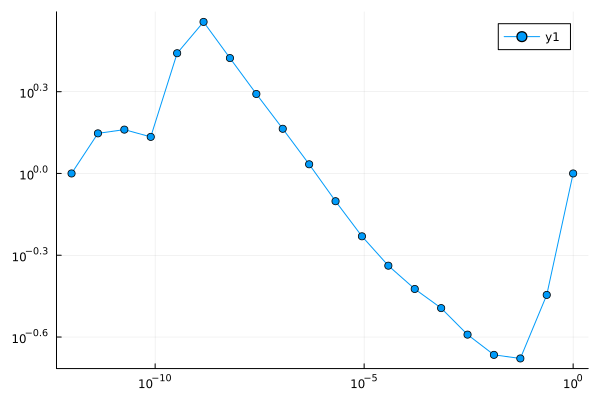

In [7]:
lam, ev, rho_l = fit_rhow(irx, gx, lamda_num, batch_num, w_mesh)
plot(lam, ev, xaxis=:log, yaxis=:log, marker=:circle)

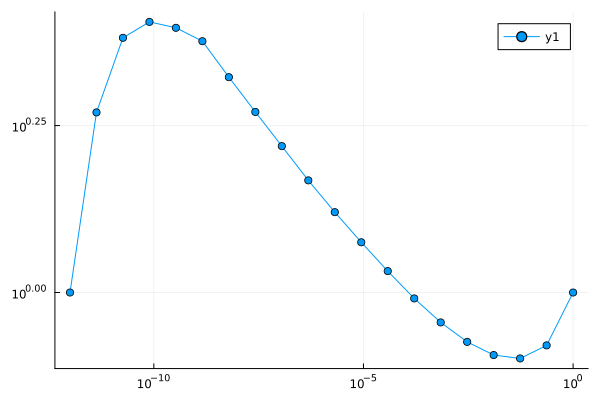

In [8]:
lam0, ev0, rho_l0 = fit_rho0w(irx, gx, lamda_num, batch_num, w_mesh)
plot(lam0, ev0, xaxis=:log, yaxis=:log, marker=:circle)

In [9]:
it0 = findmax(ev0)[2]
#println(rho_l0[it0,:])

4

In [10]:
it = findmax(ev)[2]
#println(rho_l[it,:])

6

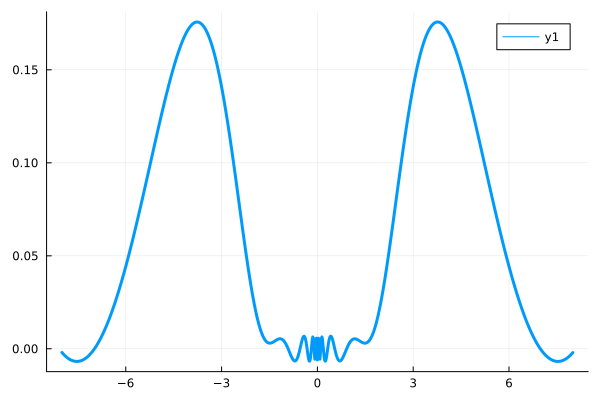

In [11]:
rho_omega = -transpose(irx.basis.v(w_mesh)) * rho_l[it,:]
plot(w_mesh, real.(rho_omega), linewidth=3.0)
#plot!(w_mesh, real.(rho_omega0), linewidth=3.0)

In [12]:
function reshapeX(rho::Vector{Float64}, cutoff::Float64 = 0.03)
    v_it::Vector{Int} = []
    rho_rep = rho
    sw = false
    for w in 1:length(rho_rep)
        if(rho_rep[w]<0)
            if(sw)
                for it in v_it
                    rho_rep[it] = 0.002         
                end
                empty!(v_it)
                sw = false
            elseif(w<length(rho_rep) && rho_rep[w+1]>rho_rep[w])
                sw = true
            end
            rho_rep[w] = 0.002
        elseif(rho_rep[w]<cutoff && sw)
            push!(v_it,w)
        elseif(rho_rep[w]>=cutoff && sw && w<length(rho_rep) && rho_rep[w+1]<rho_rep[w])
            empty!(v_it)
            sw = false
        end
    end
    return rho_rep
end

reshapeX (generic function with 2 methods)

In [13]:
rho_res2 = reshapeX(rho_omega, 0.08)

1001-element Vector{Float64}:
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 ⋮
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002
 0.002

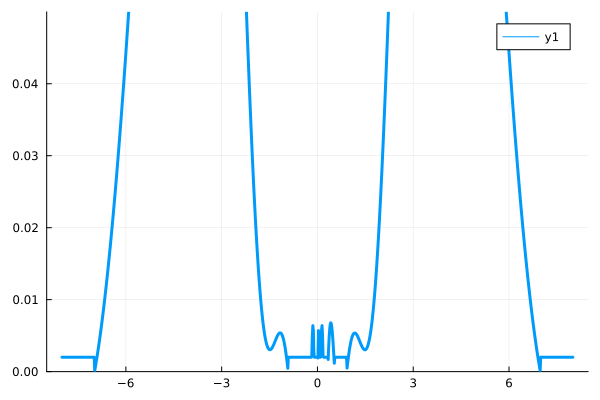

In [14]:
plot(w_mesh, rho_res2, linewidth=3.0,yrange=[0,0.05])
#, xrange=[-2,2], marker=:circle)

In [28]:
n = 0.0
f(w) = 1.0/(1.0+exp(irx.beta*w))
for w in 1:w_num
    n += dw * rho_res[w] * f(w_mesh[w])
end
println(n)
rho_res = (0.5/n) * rho_res

0.5099185065520386


1001-element Vector{Float64}:
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 ⋮
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885
 0.0019610976796307885

In [19]:
dw = 2irx.bw/(w_num-1)
function KK_GR(w::Vector{Float64}, rho::Vector{Float64})
    GR_ = zeros(ComplexF64, w_num)
    for w_re in 1:w_num
        re::Float64 = 0.0
        for w_im in 1:w_num
            if(w_im != w_re)
                re += dw * rho[w_im] / (w[w_re] - w[w_im])
            end 
        end
        GR_[w_re] = re - 1.0im * rho[w_re] * pi
    end
    return GR_
end

KK_GR (generic function with 1 method)

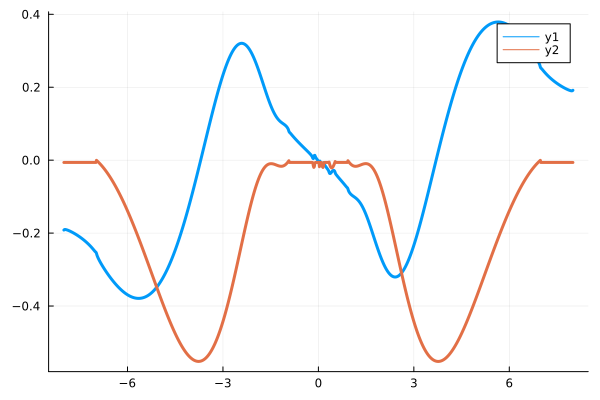

In [20]:
grr = KK_GR(w_mesh, rho_res)
plot(w_mesh, real.(grr), linewidth=3.0)
plot!(w_mesh, imag.(grr), linewidth=3.0)

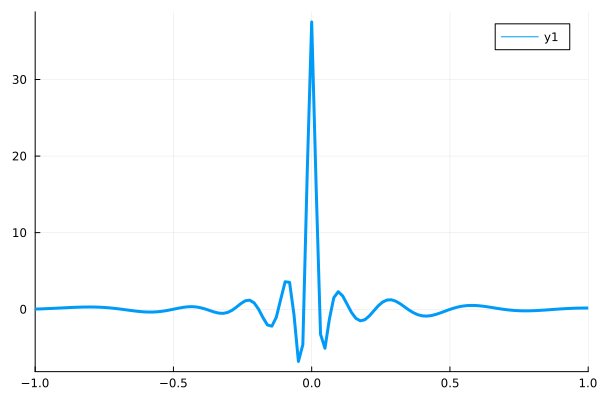

In [34]:
#rho_omega = transpose(irx.basis.v(w_mesh)) * (gx.g0_ir ./ irx.basis.s)
rho_omega0 = -transpose(irx.basis.v(w_mesh)) * rho_l0[it0,:]
plot(w_mesh, real.(rho_omega0), linewidth=3.0, xrange=[-1.0,1.0])
#plot!(w_mesh, -imag.(gw) ./ pi, linewidth=3.0)

In [36]:
rho0_res = reshapeX(rho_omega0, 0.05)
n = 0.0
f(w) = 1.0/(1.0+exp(irx.beta*w))
for w in 1:w_num
    n += dw * rho0_res[w] * f(w_mesh[w])
end
println(n)
rho0_res = (0.5/n) * rho0_res

1.865341715793792


1001-element Vector{Float64}:
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 0.0005360948031843336
 ⋮
 0.03752136063870759
 0.05134450152839173
 0.06609075987045565
 0.0817915862520562
 0.09847895830005986
 0.11618538116939767
 0.13494388793678608
 0.15478803990040468
 0.17575192678612314
 0.19787016686090528
 0.221177906954032
 0.24571082238680367

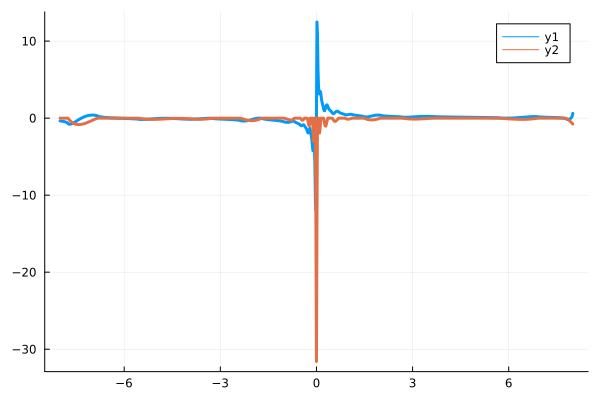

In [37]:
grr0 = KK_GR(w_mesh, rho0_res)
plot(w_mesh, real.(grr0), linewidth=3.0)
plot!(w_mesh, imag.(grr0), linewidth=3.0)

In [38]:
sigma_w2 = zeros(ComplexF64, w_num)
for ww in 1:w_num
    sigma_w2[ww] = 1.0/grr0[ww] - 1.0/grr[ww] - px.mu
end

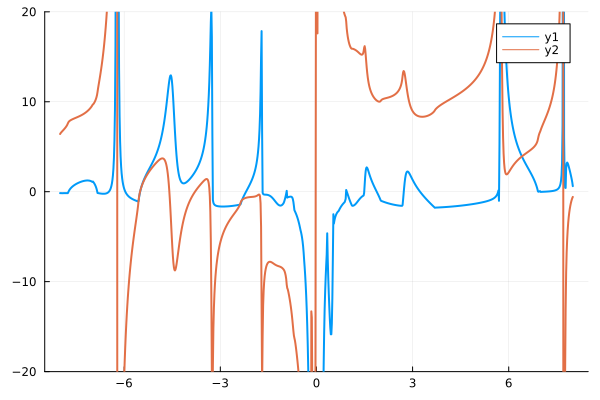

In [39]:
plot(w_mesh, imag.(sigma_w2), linewidth=2.0, yrange=[-20.0,20.0])
plot!(w_mesh, real.(sigma_w2), linewidth=2.0)

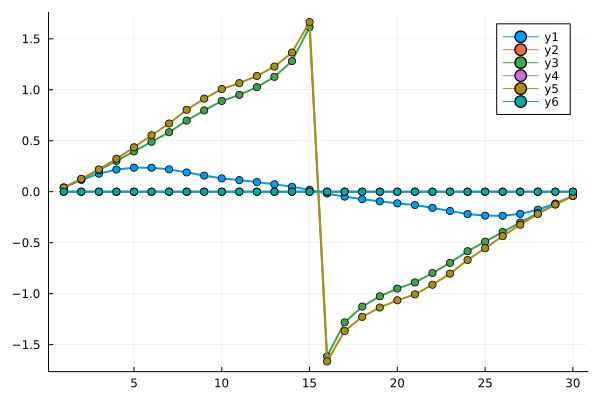

In [142]:
plot(imag.(gx.sigma_matsu), linewidth=2.0,  marker=:circle)
plot!(real.(gx.sigma_matsu), linewidth=2.0,  marker=:circle)
plot!(imag.(gx.g_matsu), linewidth=2.0,  marker=:circle)
plot!(real.(gx.g_matsu), linewidth=2.0,  marker=:circle)
plot!(imag.(gx.g0_matsu), linewidth=2.0,  marker=:circle)
plot!(real.(gx.g0_matsu), linewidth=2.0,  marker=:circle)

In [69]:
irx.smpl_tau.sampling_points

29-element Vector{Float64}:
  0.03915272343103515
  0.2088370593442468
  0.5249919445739493
  1.0084587462095285
  1.69437504156853
  2.6386667031885747
  3.9273442080802856
  5.688319723480451
  8.103914227916531
 11.420010087523968
 15.942956286771015
 22.002043880542608
 29.83579079613173
  ⋮
 77.99795611945738
 84.05704371322898
 88.57998991247604
 91.89608577208347
 94.31168027651954
 96.07265579191971
 97.36133329681142
 98.30562495843147
 98.99154125379047
 99.47500805542604
 99.79116294065575
 99.96084727656897

In [22]:
gw = zeros(ComplexF64, w_num)
for w in 1:w_num
    for i in 1:length(kk)
        e = set_H(kk[i],px) - px.mu
        gk = 1.0/(w_mesh[w] - e + 1.0im*px.eta)
        gw[w] += px.dk2 * gk
    end    
end

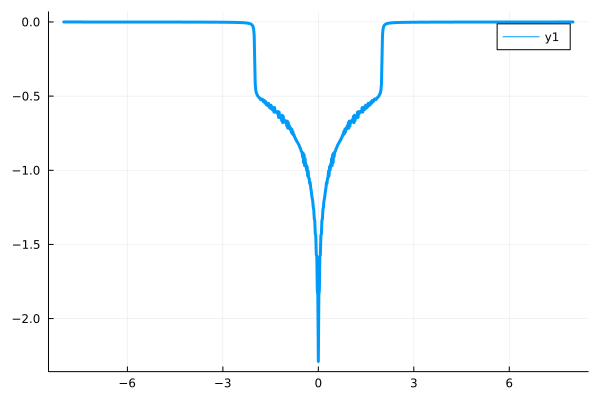

In [29]:
plot(w_mesh, imag.(gw), linewidth=3.0)